In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import pylab as plt

from sklearn import decomposition, preprocessing, cross_decomposition

from importlib import reload
import sys
import os
sys.path.insert(1,'../../make_figures')
import plots

In [3]:
def get_PCs(data,n=2):
    scaled = data.copy(deep=True)
    scale_cols = [col for col in data
             if ~(np.isin(data[col].dropna().unique(), [0, 1]).all())]
    if scale_cols:
        scaled[scale_cols] = preprocessing.StandardScaler().fit_transform(scaled[scale_cols])
    pca = decomposition.PCA(n_components=n)
    pca.fit(scaled)
    transformed = pca.transform(scaled)
    explained_var = pca.explained_variance_ratio_
    return transformed, explained_var

In [4]:
reload(plots)
image_path = plots.set_dir()
colors = plots.set_colors()

In [48]:
# load data
data = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/merged_data/unaffectedNoOsteoMatchedHC.csv')

In [44]:
data.groupby('Status')['diag_PDProdHC'].value_counts()

Status     diag_PDProdHC
Diseased   1                  153
Healthy    0                25004
Prodromal  1                  113
Name: diag_PDProdHC, dtype: int64

In [49]:
data['diagnosis'].value_counts(dropna=False)

ParkinsonDisease    532
Name: diagnosis, dtype: int64

In [7]:
name = 'ParkinsonDisease'
merged = data[data['diagnosis']==name]
# get modalities
covs = ['accelerometry_age','male']
allfeatures = merged.columns[4:100]
blood = merged.columns[100:126]
lifestyle = np.hstack([merged.columns[126:132],merged.columns[137:144]])
#lifestyle_scale = 
genetics = np.hstack([merged.columns[132:137],merged.columns[144:178]])
genetics_scale = merged.columns[144:178]
prod_acc = merged.columns[178:186]
prod = merged.columns[186:194]

In [23]:
allfeatures_scale = allfeatures.drop(['male'])

In [27]:
data.filter(regex='family').describe()

,family_Stroke,family_Diabetes,family_Severedepression,family_Alzheimersdiseasedementia,family_Parkinsonsdisease
count,25270.000000,25270.000000,25270.000000,25270.000000,25270.000000
mean,0.113930,0.194064,0.127701,0.109141,0.041037
std,0.317732,0.395486,0.333763,0.311823,0.198379
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# restrict to HC
hc = data[data['Status']=='Healthy']

In [132]:
# get modalities
covs = ['accelerometry_age','male']
acc = hc.columns[4:100]
blood = hc.columns[100:126]
lifestyle = np.hstack([hc.columns[126:132],hc.columns[137:144]])
genetics = np.hstack([hc.columns[132:137],hc.columns[144:178]])
prod_acc = hc.columns[178:186]
prod = hc.columns[186:194]

preds = np.hstack([genetics,lifestyle,blood,prod,acc,covs])

labels = pd.Series(np.hstack([np.repeat('genetics',len(genetics)),np.repeat('lifestyle',len(lifestyle)),np.repeat('blood',len(blood)),
                    np.repeat('prodromal signs',len(prod)),np.repeat('accelerometry',len(acc)),np.repeat('covariates',len(covs))]),index=preds)
color_map = dict(zip(labels.unique(),sns.color_palette('deep')))

In [137]:
corr = hc[preds].corr()

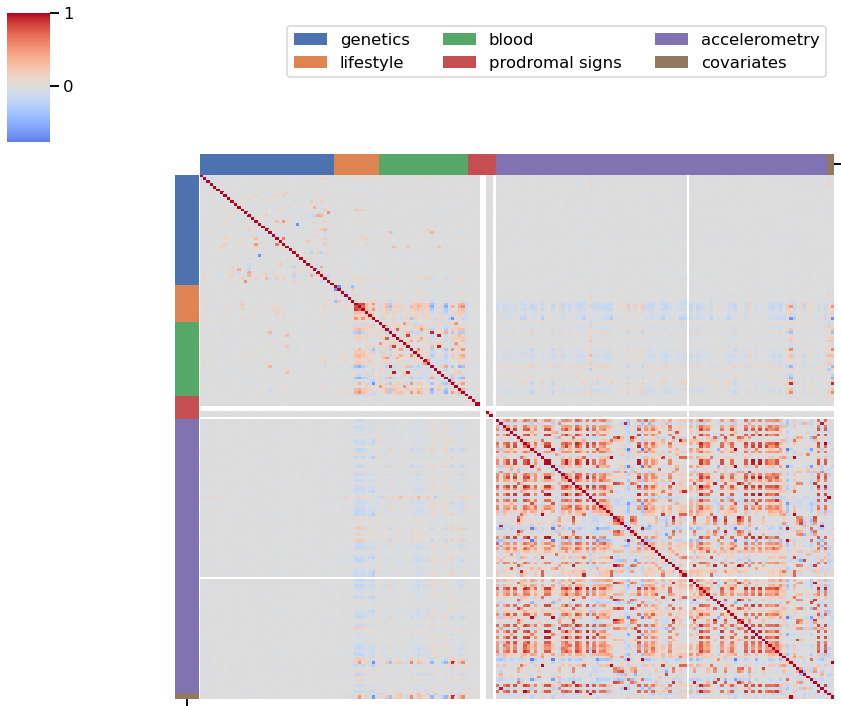

In [138]:
plots.plot_context()
g = sns.clustermap(corr.astype(float),cmap='coolwarm',center=0,col_cluster=False,row_cluster=False,
             row_colors=labels.map(color_map),col_colors=labels.map(color_map),figsize=(12,10),xticklabels=False,yticklabels=False)
# Draw the legend bar for the classes                 
for label in labels.unique():
    g.ax_col_dendrogram.bar(0, 0, color=color_map[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(bbox_to_anchor=(1,1), ncol=3);

In [166]:
# find PCs for each modality
for label,cols in zip(labels.unique()[:-1],[genetics,lifestyle,blood,prod,acc]):
    print(label,len(cols))
    pcs,variance = get_PCs(hc[cols],n=2)
    print(variance)
    print(pcs.shape)
    hc[f'{label}_1'] = pcs[:,0]
    try:
        hc[f'{label}_2'] = pcs[:,1]
    except:
        pass

genetics 39
[0.06881293 0.05909892]
(25004, 2)
lifestyle 13
[0.40421542 0.14574238]
(25004, 2)
blood 26


<ipython-input-166-808f0219bd2d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc[f'{label}_1'] = pcs[:,0]
<ipython-input-166-808f0219bd2d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc[f'{label}_2'] = pcs[:,1]
<ipython-input-166-808f0219bd2d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

[0.16631025 0.12437397]
(25004, 2)
prodromal signs 8
[0.62018558 0.24626752]
(25004, 2)
accelerometry 96
[0.27088586 0.13848722]
(25004, 2)


<ipython-input-166-808f0219bd2d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc[f'{label}_1'] = pcs[:,0]
<ipython-input-166-808f0219bd2d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hc[f'{label}_2'] = pcs[:,1]


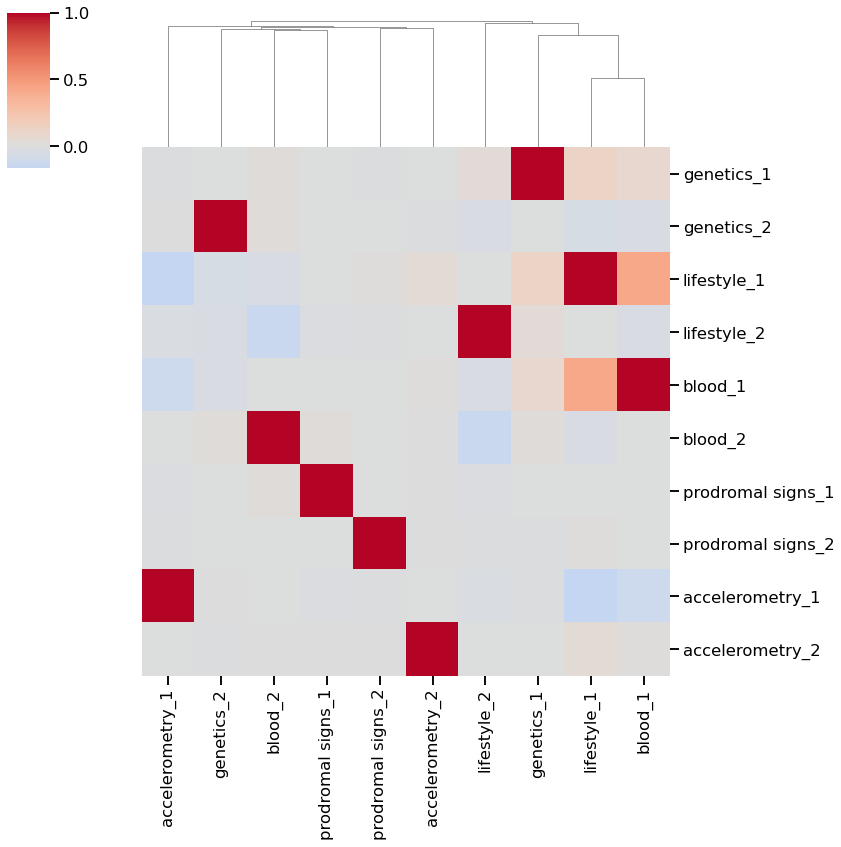

In [167]:
corr = hc.iloc[:,-10:].corr()
plots.plot_context()
g = sns.clustermap(corr.astype(float),cmap='coolwarm',center=0,figsize=(12,12),xticklabels=True,yticklabels=True,row_cluster=False)